# Classification Notebook

In [9]:
# Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


## Import Dataset

In [10]:
# use subset for development 
#TODO: change it
data = pd.read_csv('datasets/training_data.csv')

# use subset for development 
subset_data = data.head(500)


## Fit and eval model with input data

In [11]:
def train_test_model(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    results = {}
    results['accuracy'] = accuracy_score(Y_test, y_pred)
    results['precision'] = precision_score(Y_test, y_pred, average='weighted')
    results['recall'] = recall_score(Y_test, y_pred, average='weighted')
    results['f1'] = f1_score(Y_test, y_pred, average='weighted')
    results['confusion_matrix'] = confusion_matrix(Y_test, y_pred)
    results['model'] = model
    results['y_pred'] = y_pred
    return results

In [12]:
def display_confusion_matrix(matrix):
    # Display the confusion matrix as an image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(matrix, annot=True, fmt='d')
    # Set the labels
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_title('Confusion Matrix', fontsize=20)
    plt.show()
    

## CountVectorizer

In [13]:
def countVectorizerAux(data, ngram_range_max):
    #TODO: change the lowercase
    vectorizer = CountVectorizer(analyzer='word', lowercase=False, stop_words='english', ngram_range=(1, ngram_range_max))
    X = vectorizer.fit_transform(data['text']).toarray()
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    results = {}
    results['X_train'] = X_train
    results['X_test'] = X_test
    results['y_train'] = y_train
    results['y_test'] = y_test
    return results

## TfidfVectorizer

In [14]:
def tfidfVectorizerAux(data, ngram_range_max):
    #TODO: change the lowercase
    vectorizer = TfidfVectorizer(analyzer='word', lowercase=False, stop_words='english', ngram_range=(1, ngram_range_max))
    X = vectorizer.fit_transform(data['text']).toarray()
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    results = {}
    results['X_train'] = X_train
    results['X_test'] = X_test
    results['y_train'] = y_train
    results['y_test'] = y_test
    return results

## Results

### CountVectorized

#### NB 

##### Unigram

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.64 0.7718846153846153 0.64 0.6759514435695538


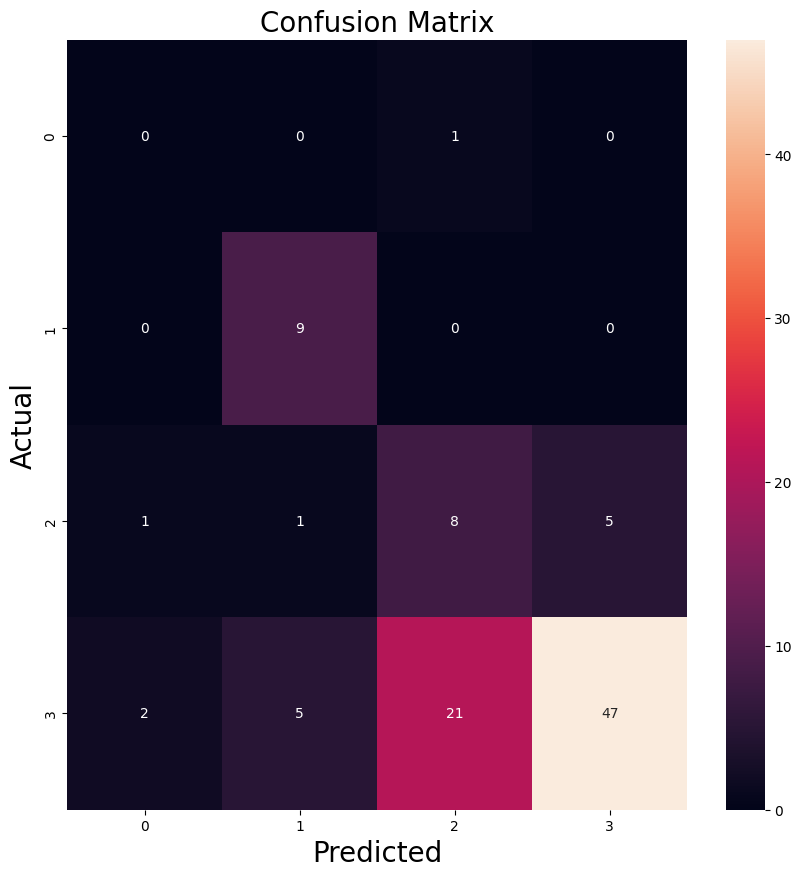

In [15]:
countVectorizerResults = countVectorizerAux(subset_data, 1)
print(countVectorizerResults['X_train'])
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Bigram

0.54 0.7864746376811594 0.54 0.583584693877551


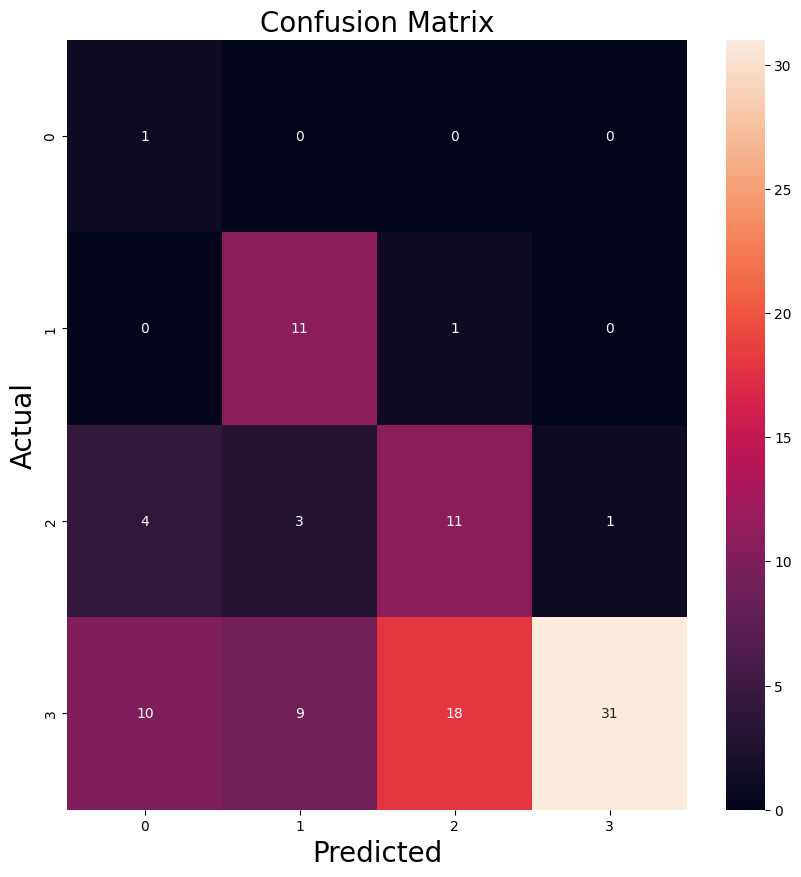

In [16]:
countVectorizerResults = countVectorizerAux(subset_data, 2)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Trigram

0.25 0.859015922158337 0.25 0.2783309593632174


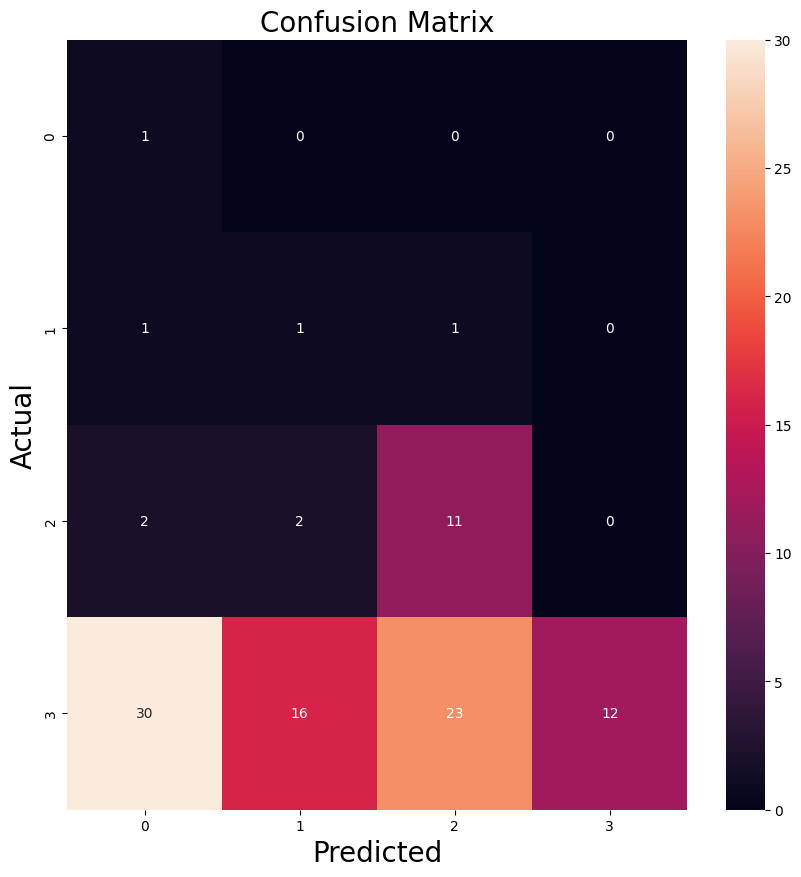

In [17]:
countVectorizerResults = countVectorizerAux(subset_data, 3)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

#### DTC

##### Unigram

0.73 0.7152619047619048 0.73 0.7192504835589942


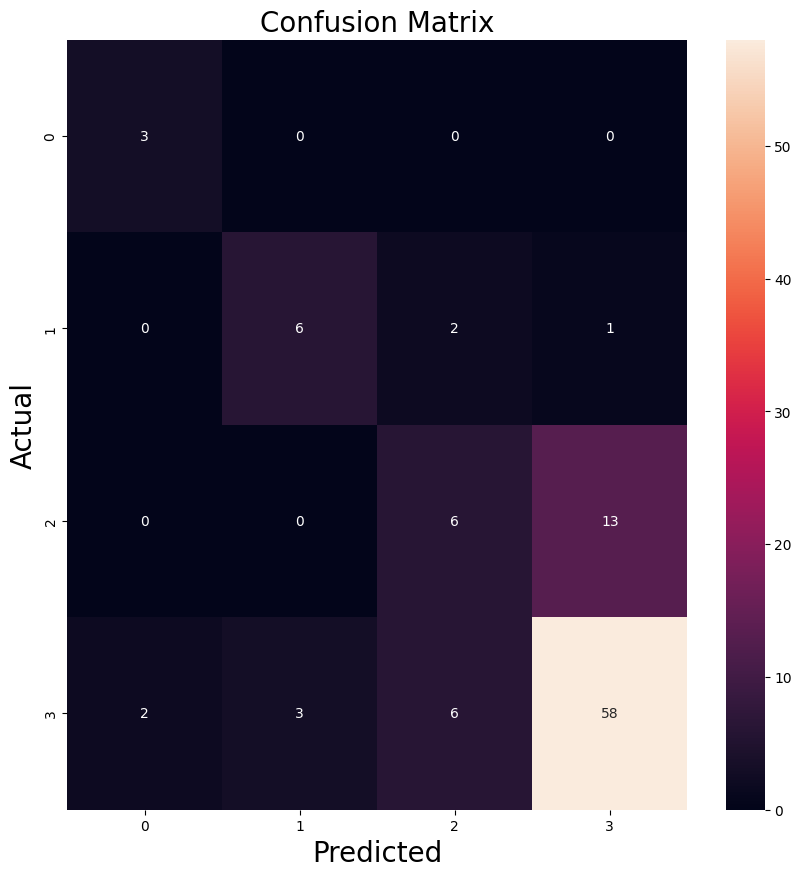

In [18]:
vectorizerResults = countVectorizerAux(subset_data, 1)
results_nb_simple = train_test_model(
    DecisionTreeClassifier(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Bigram

/home/lucas/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.72 0.6596536796536796 0.72 0.6857311866215976


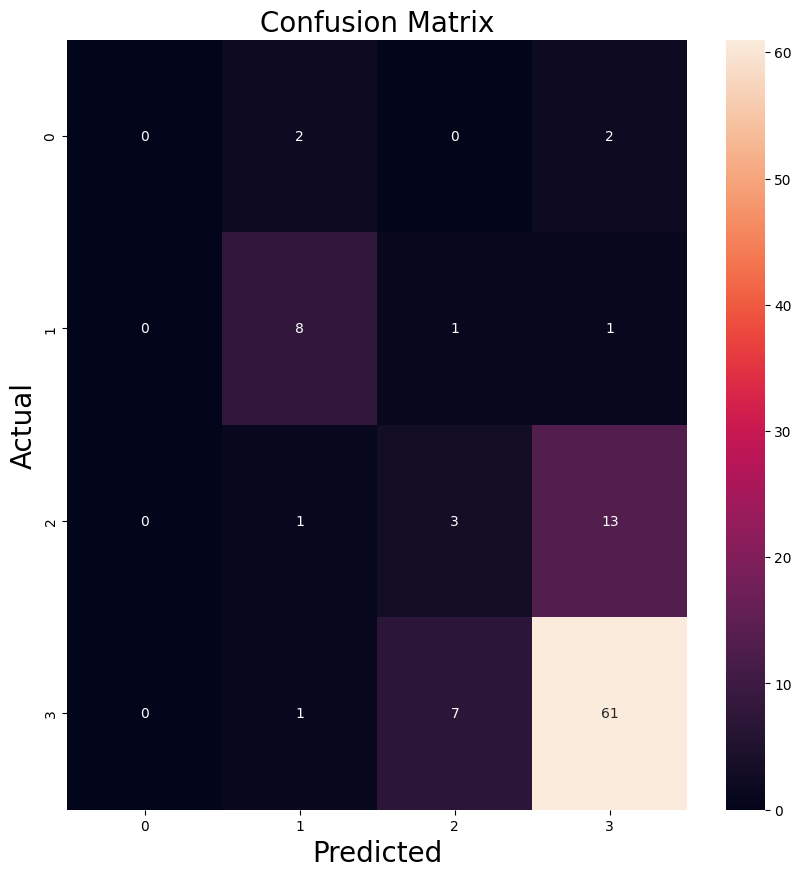

In [19]:
vectorizerResults = countVectorizerAux(subset_data, 2)
results_nb_simple = train_test_model(
    DecisionTreeClassifier(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Trigram

0.75 0.7178888888888889 0.75 0.7117613765958519


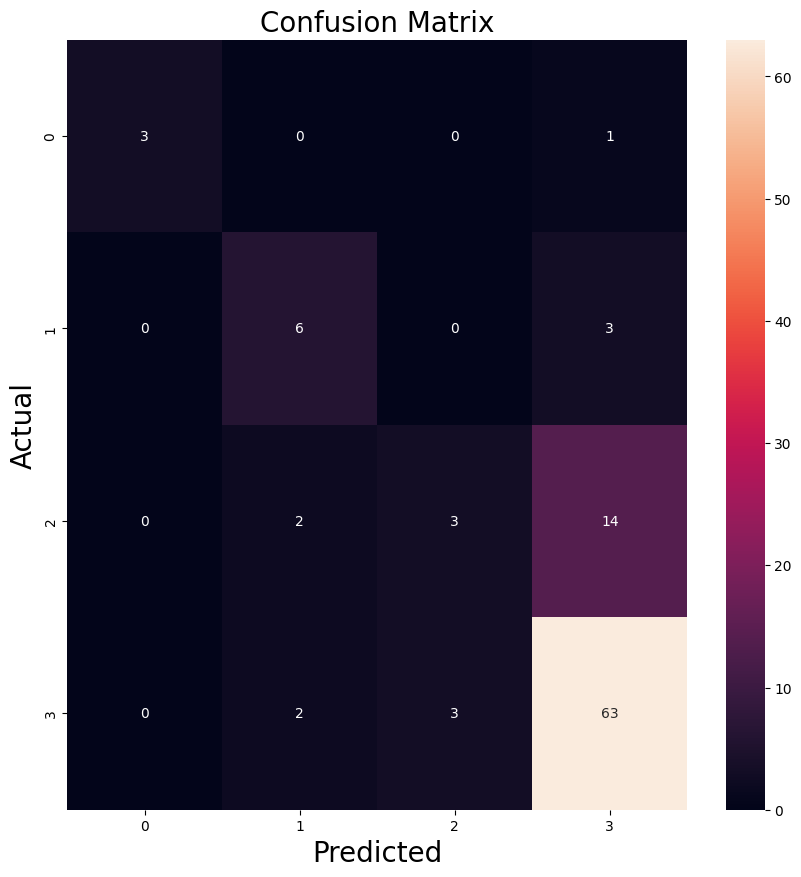

In [20]:
vectorizerResults = countVectorizerAux(subset_data, 3)
results_nb_simple = train_test_model(
    DecisionTreeClassifier(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

### TFIDF Vectorizerd

#### NB

##### Unigram

/home/lucas/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.73 0.5329 0.73 0.6160693641618498


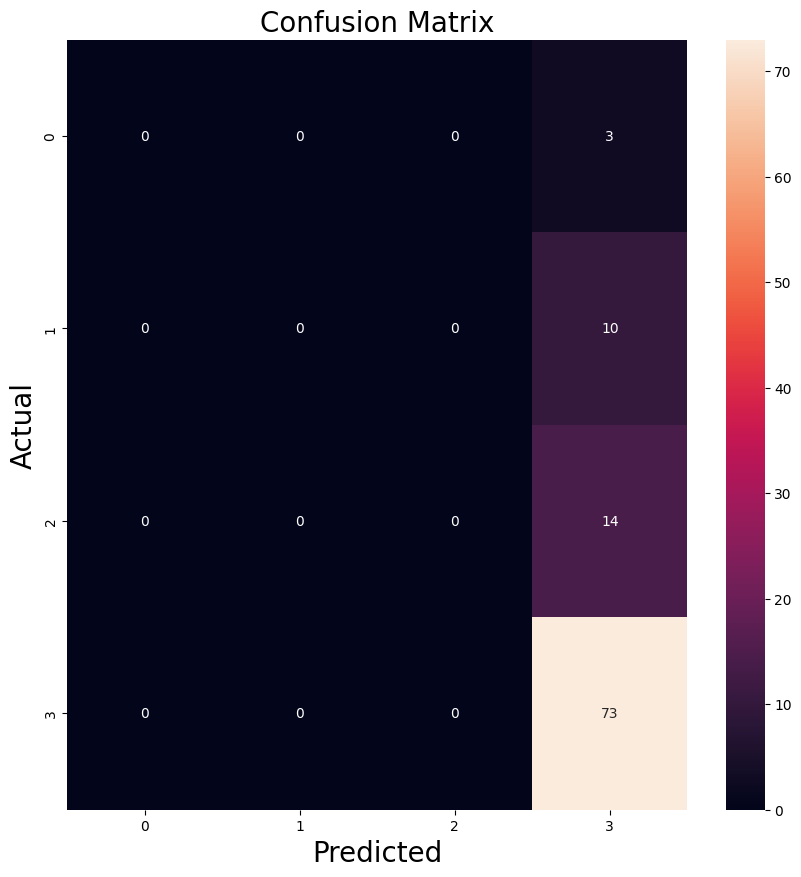

In [21]:
vectorizerResults = tfidfVectorizerAux(subset_data, 1)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Bigram

/home/lucas/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.65 0.4225 0.65 0.5121212121212122


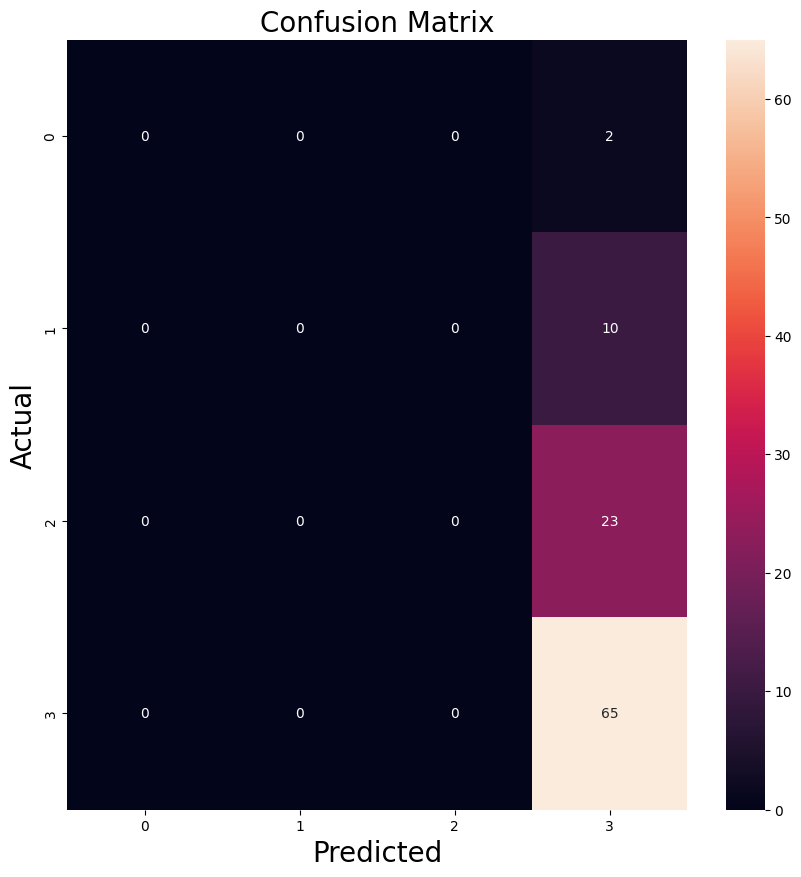

In [22]:
vectorizerResults = tfidfVectorizerAux(subset_data, 2)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Trigram

/home/lucas/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.81 0.6561 0.81 0.7249723756906077


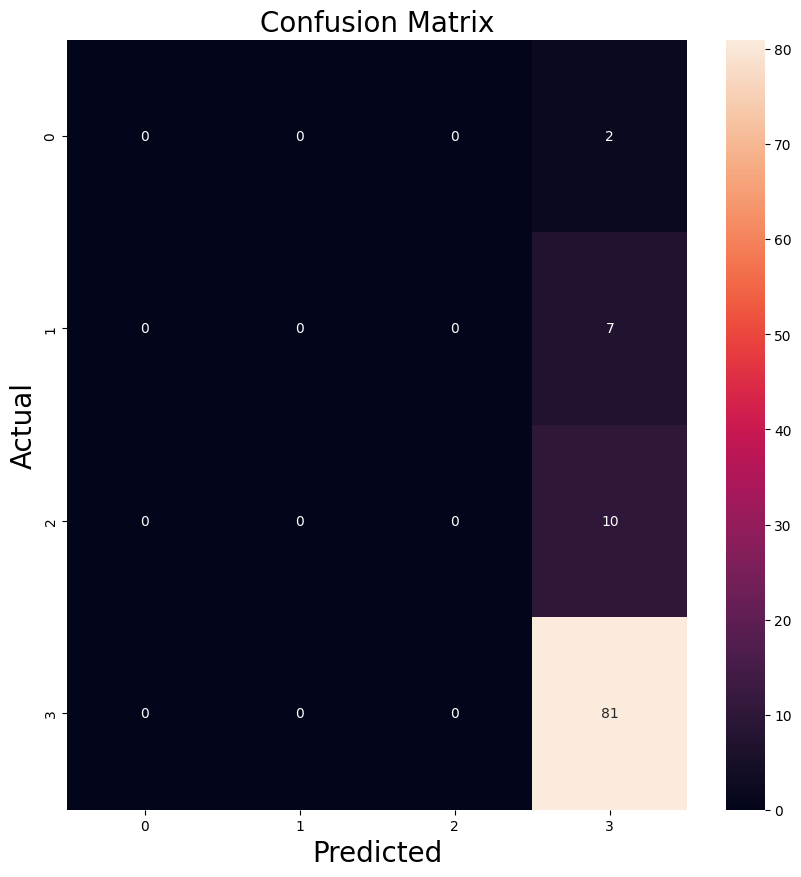

In [23]:
vectorizerResults = tfidfVectorizerAux(subset_data, 3)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])